In [4]:
import itertools

import matplotlib.pyplot as plt
import numpy as np


def average_sequence() -> int:
    rng = np.random.default_rng()

    s = 0
    for i in itertools.count(1):
        s += rng.integers(1, 11)
        yield int(100 * s / i)


def simulation(days: int, iterations: int):
    res = np.zeros((1001, days), dtype=int)
    
    for _ in range(iterations):
        average = average_sequence()
        for d in range(days):
            a = next(average)
            res[a][d] += 1
            
    return res

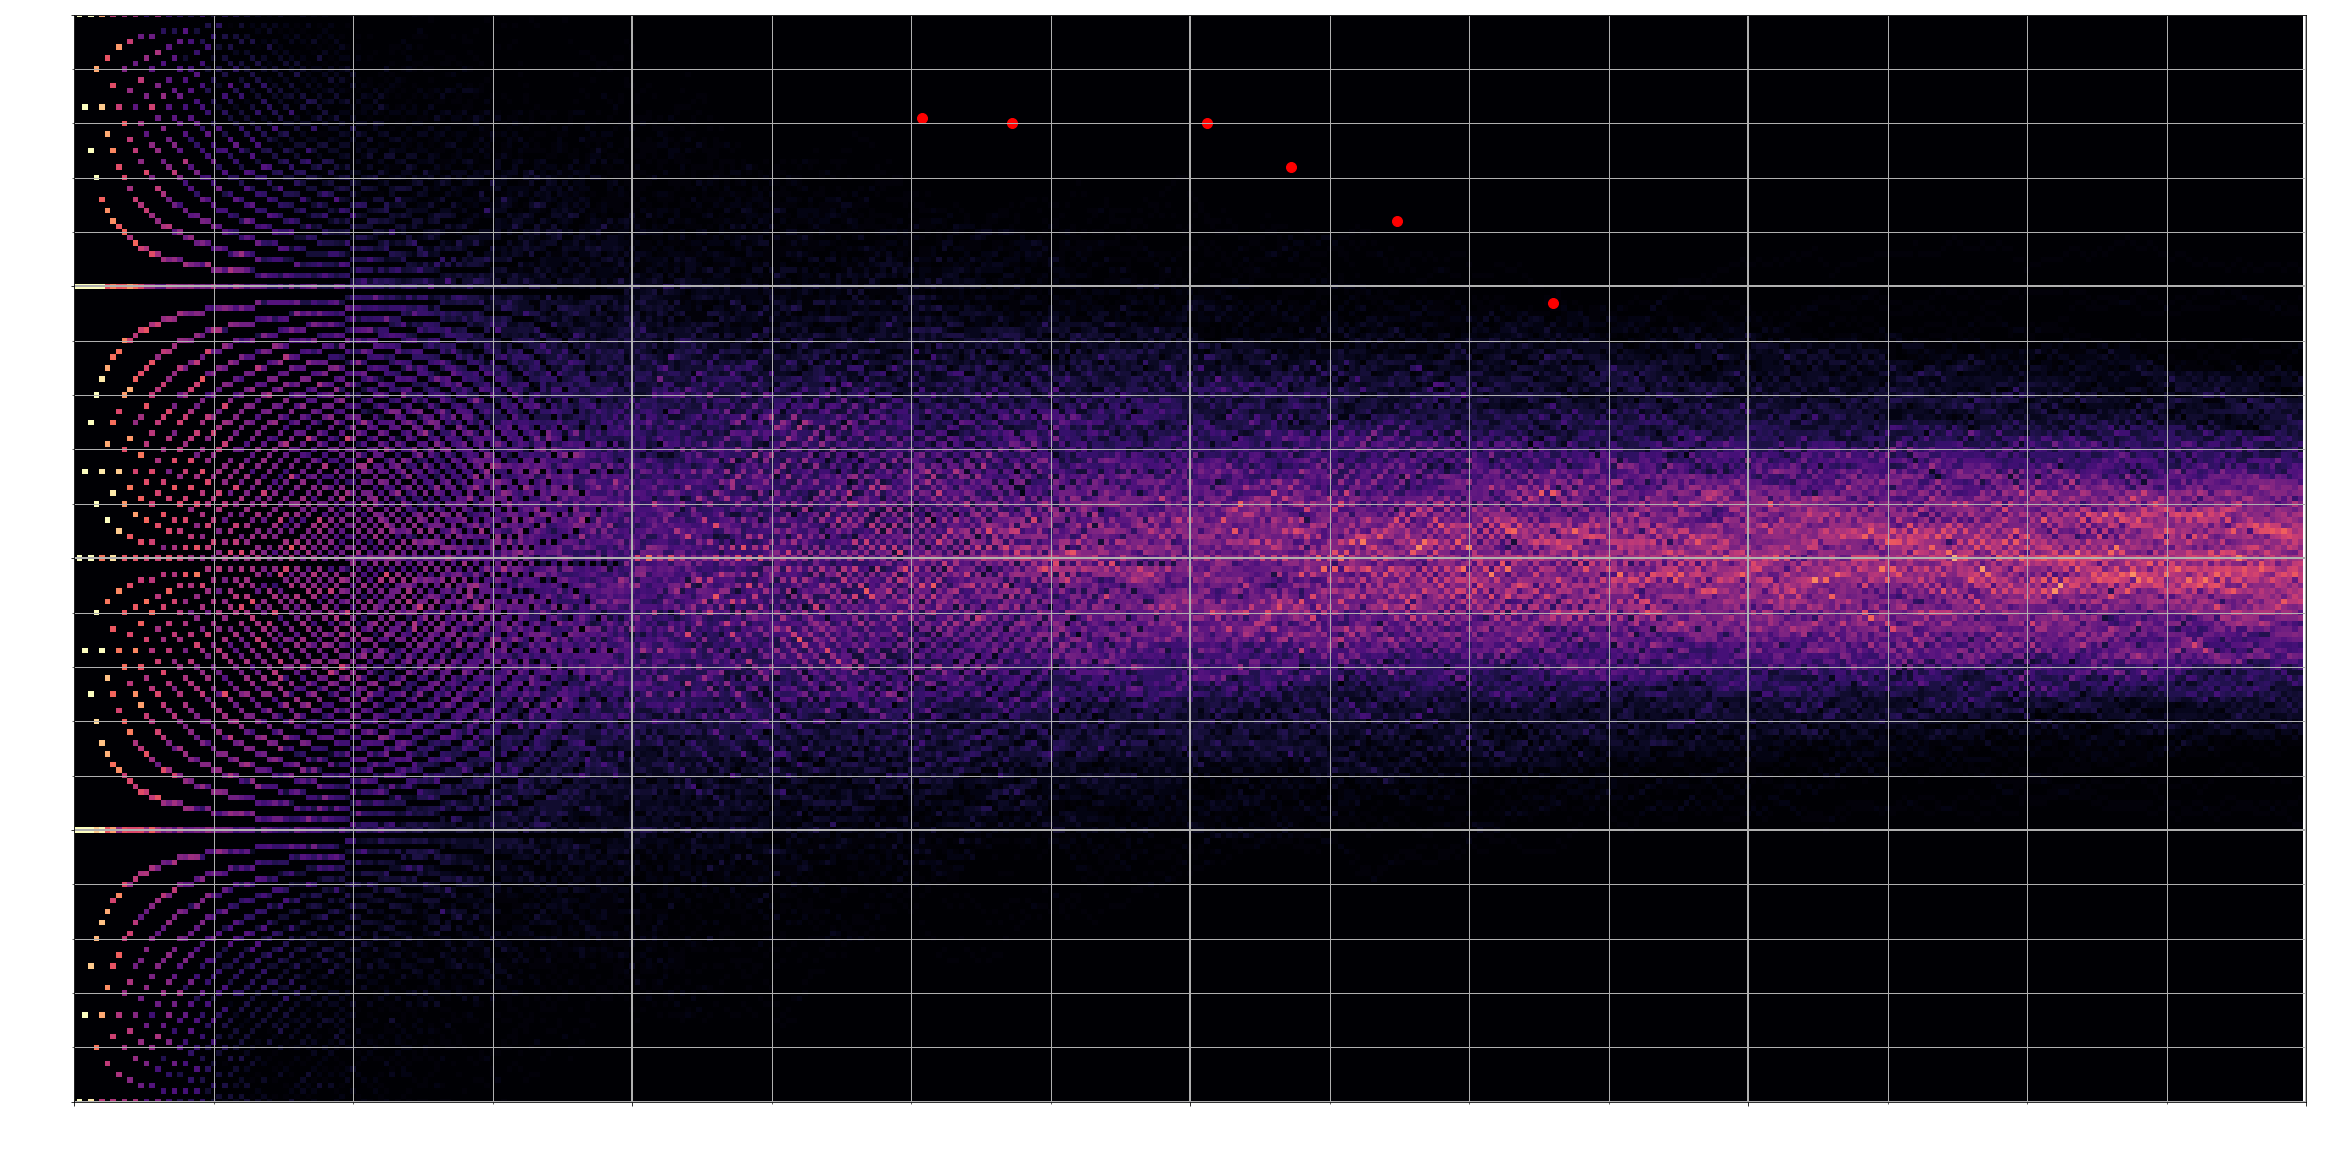

In [21]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from multiprocessing import Pool, cpu_count
from pathlib import Path

days = 400
iters = 1_000
cpus = cpu_count()

with Pool(processes=cpus) as pool:
    work = [(days, iters // cpus)] * cpus
    data = sum(pool.starmap(simulation, work))
    
actual=[
    (152, 6.31), (168, 6.30), (203, 6.30), 
    (218, 6.22), (237, 6.12), (265, 5.97),
    (275, 5.92), (293, 5.94), (307, 5.96),
    (331, 5.93), (353, 5.96), (374, 5.94),]
    
fig, ax = plt.subplots(figsize=(40, 20))

max_val = np.amax(data)
cmap="magma"

im = ax.pcolormesh(
    np.arange(0, days, 1), 
    np.arange(0, 10.01, 0.01), 
    data, cmap=cmap, shading="auto", vmin=0, vmax=max_val / 2)

ax.scatter(*zip(*actual), marker='o', s=100, color="red")

ax.set_xlim([0, days])
ax.set_ylim([4.50, 6.50])

text_color = "white"

plt.ylabel("среднее", fontsize=24, color=text_color)
plt.xlabel("дни", fontsize=24, color=text_color)

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.yticks(fontsize=20, color=text_color)
plt.xticks(fontsize=20, color=text_color)

ax.grid(which="major", axis="both", linestyle="-", linewidth=2)
ax.grid(which="minor", axis="both", linestyle="-", linewidth=1)

plt.show()

image_path="./images"
Path(image_path).mkdir(exist_ok=True)
fig.savefig(f"{image_path}/average_{days}d_{iters}i_{cmap}_{text_color}.png")